In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns



In [5]:
df = pd.read_csv('gaming_video_stats.csv', encoding='latin-1')
df['PublishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')
df.dropna()
df['logViews'] = np.log(df['viewCount']+1)

In [4]:
df.columns

Index([u'viewCount', u'likeCount', u'dislikeCount', u'favoriteCount',
       u'commentCount', u'title', u'description', u'publishedAt', u'video Id',
       u'channel Id'],
      dtype='object')

High level overview of what I want to do is this:

The `prolific_channels` pandas dataframe has a bunch of entries corresponding to videos from channels that have published more than 50 videos. What I want to be able to do is, for each channel that has more than 50 videos, get the rowHash (index in the dataframe) of the most recently uploaded video. Then, for each of those most recently uploaded videos per channel, we want to get statistics for the last 10 or so videos uploaded before that one. Each of these stats will be a feature in our regression. And then after defining a dataframe for that (which I'll refer to as `df`) and putting those features in it, we call a GradientBoostingRegressor as follows.

In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

#features = ['last_video_views', '2nd_to_last_views', ... 'views_from_10_videos_ago',
#            'last_video_comment_count', same for the others...]

X = df[features]
y = df['Views']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
print "R^2: {0}".format(reg.score(X_test, y_test))

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=features)

And then in addition to that regressor, which is a view count predictor based on stats specific to the channel in question, we'll also want another regressor that looks at coarser channel stats like that other group did (total subscribers, total videos, total view counts, etc), and then just based on those try to come up with an estimate of the view counts for the most recent uploads to a channel. And then combine those regressors somehow.

In [11]:
channels = {}
for _, video in df.iterrows():
    channel_id = video['channel Id']
    if not channel_id in channels:
        channels[channel_id] = [video]
    else:
        channels[channel_id].append(video)
for channel_id in channels:
    channels[channel_id] = sorted(channels[channel_id], key=lambda v: v['PublishedAt'])

In [21]:
from random import shuffle
def prediction_answer_and_feature_extractor(channel, n):
    """
    I'm assuming the thing that's passed in is a list of videos,
    in other words a channel is a value in the channels dict.
    This also assumes that 
    
    This takes one of those entries and returns a tuple, one value of which
    is the correct view count that we want to predict for the most recent video
    posted to the channel, and the second is a dictionary containing feature names
    and feature values of the previous 10 videos before the most recent one.
    """
    if len(channel) < n+1:
        raise Exception("Not enough videos in channel to create a feature vector.")
        
    video_stat_names = ['likeCount', 'dislikeCount', 'viewCount', 
                'commentCount']
    correct_prediction = channel[-1]['logViews']
    feature_values = []
    feature_names = []
    tmp_channel = list(channel)
    shuffle(tmp_channel)
    for i in range(-2,-n-2,-1):
        feature_values += list(tmp_channel[i][video_stat_names])
        feature_names += [name + "%d"%(i+1) for name in video_stat_names]
    return (correct_prediction, dict(zip(feature_names, feature_values)))

The above will definitely fail since the entries in ~channels~ are often going to be shorter than n (which we'll set to 5 or 10 or something). Which is why we need to use the YouTube API to loop through all channel ids in channels and populate the list with the last 15 videos posted to that channel.

In [15]:
prolific_channels = {k:v for k, v in channels.items() if 11 < len(v)}

In [63]:
prediction_answer_and_feature_extractor(prolific_channels.iteritems()[0][1], 5)

AttributeError: 'dict' object has no attribute 'iteritems'

In [16]:
data = []
for channel_id, vids in nlp_channels.items():
    answer, vid_features = prediction_answer_and_feature_extractor(vids, 5)
    vid_features['trueViewCount'] = answer
    data.append(vid_features)

In [55]:
channel

'UCa0o4WDOq1kJAyMETrPnpQg'

In [65]:
Y = pd.DataFrame(answers)

NameError: name 'answers' is not defined

In [87]:
df.columns

Index([u'commentCount-1', u'commentCount-10', u'commentCount-2',
       u'commentCount-3', u'commentCount-4', u'commentCount-5',
       u'commentCount-6', u'commentCount-7', u'commentCount-8',
       u'commentCount-9', u'dislikeCount-1', u'dislikeCount-10',
       u'dislikeCount-2', u'dislikeCount-3', u'dislikeCount-4',
       u'dislikeCount-5', u'dislikeCount-6', u'dislikeCount-7',
       u'dislikeCount-8', u'dislikeCount-9', u'favoriteCount-1',
       u'favoriteCount-10', u'favoriteCount-2', u'favoriteCount-3',
       u'favoriteCount-4', u'favoriteCount-5', u'favoriteCount-6',
       u'favoriteCount-7', u'favoriteCount-8', u'favoriteCount-9',
       u'likeCount-1', u'likeCount-10', u'likeCount-2', u'likeCount-3',
       u'likeCount-4', u'likeCount-5', u'likeCount-6', u'likeCount-7',
       u'likeCount-8', u'likeCount-9', u'trueViewCount', u'viewCount-1',
       u'viewCount-10', u'viewCount-2', u'viewCount-3', u'viewCount-4',
       u'viewCount-5', u'viewCount-6', u'viewCount-7', u'vi

In [17]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

features = ['likeCount', 'dislikeCount', 'viewCount', 'commentCount']
real_features = [name+'-%d'%i for i in range(1,6) for name in features]
df = pd.DataFrame(data)
df = df.dropna()
X = df[real_features]
y = df['trueViewCount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
print("R^2: {0}".format(reg.score(X_test, y_test)))
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=real_features)

KeyError: "['likeCount-1' 'dislikeCount-1' 'viewCount-1' 'commentCount-1'\n 'likeCount-2' 'dislikeCount-2' 'viewCount-2' 'commentCount-2'\n 'likeCount-3' 'dislikeCount-3' 'viewCount-3' 'commentCount-3'\n 'likeCount-4' 'dislikeCount-4' 'viewCount-4' 'commentCount-4'\n 'likeCount-5' 'dislikeCount-5' 'viewCount-5' 'commentCount-5'] not in index"

In [34]:
real_features #R^2 = .646

['likeCount-1',
 'dislikeCount-1',
 'viewCount-1',
 'favoriteCount-1',
 'commentCount-1',
 'likeCount-2',
 'dislikeCount-2',
 'viewCount-2',
 'favoriteCount-2',
 'commentCount-2',
 'likeCount-3',
 'dislikeCount-3',
 'viewCount-3',
 'favoriteCount-3',
 'commentCount-3',
 'likeCount-4',
 'dislikeCount-4',
 'viewCount-4',
 'favoriteCount-4',
 'commentCount-4',
 'likeCount-5',
 'dislikeCount-5',
 'viewCount-5',
 'favoriteCount-5',
 'commentCount-5']

In [2]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

0.7315795291960427


/Users/jonbraatz/Desktop/Fall 2018/CS 221/project/.venv3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


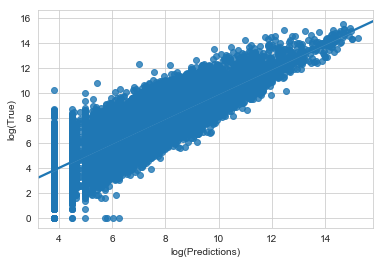

In [9]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)
print(xgb.score(X_test, y_test))
y_pred = xgb.predict(X_test)
plot_df = pd.DataFrame(y_pred, columns=['log(Predictions)'])
plot_df['log(True)'] = np.array(y_test)
sns.regplot(x='log(Predictions)', y='log(True)', data=plot_df)

In [3]:
XGBRegressor()

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [153]:
y_test
i = 0
for 

2590     2.639057
1893     9.138952
1351     3.610918
1367     5.123964
2788     4.779123
458      8.235891
2318     9.115810
3194     5.379897
395      3.806662
1970     7.174724
2323     5.973810
3142     4.317488
1603     6.152733
2658     5.517453
1995     3.970292
1887     6.806829
1283     7.495542
2623     5.953243
1949    10.506026
124      5.517453
1688     9.869207
3134    11.179939
53       8.148446
1833     8.850231
1671     2.079442
553      5.918894
1016     6.862758
462      4.262680
2654     5.958425
2838     4.454347
          ...    
1809     4.969813
807      6.466145
3141    10.315730
2478    11.396830
1400     6.893656
900      6.650279
1900     4.867534
73       6.049733
1427     3.496508
92       1.609438
2801     6.857514
1923     6.682109
1353     5.752573
1270     5.017280
2662     3.828641
2380     1.609438
1058     2.639057
1038     6.194405
1691     3.970292
1462    11.008479
1944     1.098612
1947    11.141354
1676     3.583519
613      8.418698
414      4

In [19]:
import spacy

nlp = spacy.load('en_core_web_lg')

In [20]:
nlp_channels = {}
for channel_id, vids in prolific_channels.items():
    title_desc = nlp("{} {}".format(vids[-1]['title'], vids[-1]['description']))
    similarities = [title_desc.similarity(nlp("{} {}".format(vid['title'], vid['description']))) for vid in vids[:-1]]
    vids_and_sims = zip(similarities, vids)
    nlp_channels[channel_id] = [v[1] for v in sorted(vids_and_sims, key=lambda k:k[0])]



In [25]:
len(nlp_channels)

1435

In [22]:
nlp_channels

{'UCwRGQapSgTW9xba17OCjgXA': [viewCount                                    111
  likeCount                                      3
  dislikeCount                                   0
  favoriteCount                                  0
  commentCount                                   1
  title            Team Fortress 2 - Messing About
  description                           Fun! Later
  publishedAt             2012-06-03T20:06:40.000Z
  video Id                             jfGBh5IM38c
  channel Id              UCwRGQapSgTW9xba17OCjgXA
  PublishedAt                  2012-06-03 20:06:40
  logViews                                  4.7185
  Name: 17, dtype: object,
  viewCount                                                     1185
  likeCount                                                       10
  dislikeCount                                                     2
  favoriteCount                                                    0
  commentCount                                           

In [206]:
import collections

def cosine_similarity(title1, title2):
    title1 = str(title1)
    title2 = str(title2)
    bag1 = collections.defaultdict(int)
    bag2 = collections.defaultdict(int)
    for word in title1.split():
        bag1[word] += 1
    for word in title2.split():
        bag2[word] += 1
     
    result = 0
    for word in bag1:
        if word in bag2:
            result += bag1[word] * bag2[word]
    norm1 = sum([v**2 for v in bag1.values()])**(1/2.)
    norm2 = sum([v**2 for v in bag2.values()])**(1/2.)
    result /= (norm1 * norm2)
    return result


In [10]:
y_test_list = list(y_test)
sum([(y_test_list[i]-y_pred[i])**2 for i in range(1024)])/1024.

1.5604569170551388

[(0.0, viewCount                                540
  likeCount                                  1
  dislikeCount                               2
  favoriteCount                              0
  commentCount                               1
  title            A Super Maconha das Maconha
  description                              NaN
  publishedAt         2016-08-29T13:17:46.000Z
  video Id                         Uw-N_KqvbAY
  channel Id          UCa0o4WDOq1kJAyMETrPnpQg
  PublishedAt              2016-08-29 13:17:46
  logViews                             6.29342
  Name: 49844, dtype: object),
 (0.0, viewCount                                6403
  likeCount                                  35
  dislikeCount                                3
  favoriteCount                               0
  commentCount                                8
  title            Onda gigante engole surfista
  description                               NaN
  publishedAt          2016-09-01T23:43:12.000Z
  video Id 

[viewCount                                540
 likeCount                                  1
 dislikeCount                               2
 favoriteCount                              0
 commentCount                               1
 title            A Super Maconha das Maconha
 description                              NaN
 publishedAt         2016-08-29T13:17:46.000Z
 video Id                         Uw-N_KqvbAY
 channel Id          UCa0o4WDOq1kJAyMETrPnpQg
 PublishedAt              2016-08-29 13:17:46
 logViews                             6.29342
 Name: 49844, dtype: object, viewCount                                6403
 likeCount                                  35
 dislikeCount                                3
 favoriteCount                               0
 commentCount                                8
 title            Onda gigante engole surfista
 description                               NaN
 publishedAt          2016-09-01T23:43:12.000Z
 video Id                          WmyM9h4M6

R^2: 0.7316192558752473


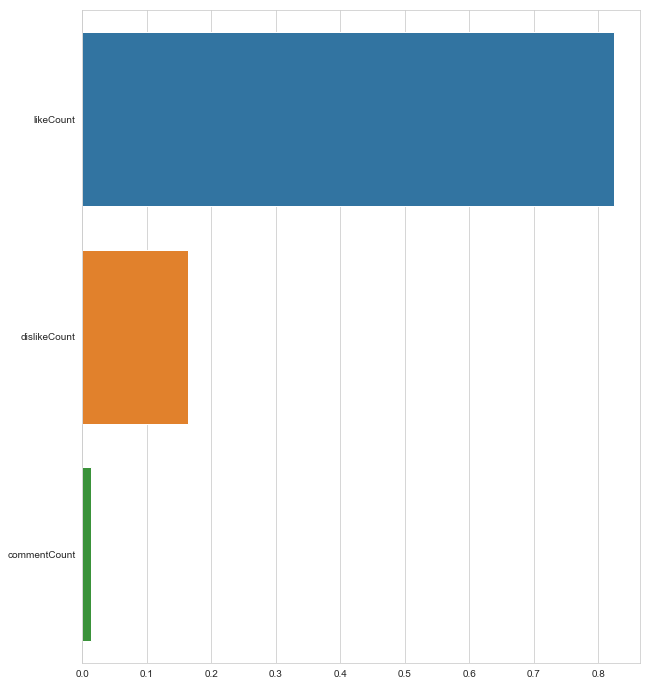

In [7]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

features = ['likeCount', 'dislikeCount', 'commentCount']
#real_features = [name+'-%d'%i for i in range(1,6) for name in features]
#df = pd.DataFrame(data)
df = df.dropna()
X = df[features]
y = df['logViews']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
print("R^2: {0}".format(reg.score(X_test, y_test)))
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=features)

In [67]:
data[1]

{'likeCount-1': 4.0,
 'dislikeCount-1': 2.0,
 'viewCount-1': 583.0,
 'commentCount-1': 2.0,
 'likeCount-2': 25.0,
 'dislikeCount-2': 0.0,
 'viewCount-2': 2347.0,
 'commentCount-2': 5.0,
 'likeCount-3': 34.0,
 'dislikeCount-3': 0.0,
 'viewCount-3': 3446.0,
 'commentCount-3': 4.0,
 'likeCount-4': 49.0,
 'dislikeCount-4': 0.0,
 'viewCount-4': 13034.0,
 'commentCount-4': 3.0,
 'likeCount-5': 25.0,
 'dislikeCount-5': 0.0,
 'viewCount-5': 2138.0,
 'commentCount-5': 12.0,
 'trueViewCount': 7.01571242048723}